In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ion()

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from nltk.tokenize import word_tokenize

from tqdm import tqdm

from models.transformer import Transformer

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
device

'cuda'

## Hyper Parameters

In [3]:
num_epochs = 20
learning_rate = 1e-3
batch_size = 32
max_sequence_length = 16

## Load data and pre process

In [4]:
data = pd.read_csv('data/eng_french.csv')

In [5]:
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [6]:
class Word2Index:
    def __init__(self, language, sentences):
        self.language = language

        self.map = dict()
        self.reverse_map = list()

        self.add_word('<padding>')
        self.add_word('<unk>')

        for sent in sentences:
            for word in sent:
                self.add_word(word)

    def add_word(self, word):
        if word not in self.map:
            self.map[word] = len(self.map)
            self.reverse_map.append(word)

    def get_index(self, word):
        if word in self.map:
            return self.map[word]
        
        return self.map['<unk>']

    def indexify_sentence(self, sentence):
        return [self.get_index(word) for word in sentence]

    def get_word(self, index):
        if index < len(self.map):
            return self.reverse_map[index]
        
        return '<unk>'

    def sentencify_indices(self, indices):
        return [self.get_word(index) for index in indices]

    def __repr__(self):
        return f'{self.__class__}\n\tLanguage: {self.language}\n\tWords: {len(self.map)}'

    def __len__(self):
        return len(self.map)

In [7]:
class TranslationDataset(Dataset):
    def __init__(self, data, src_language, tgt_language, max_length=16):
        self.max_length = max_length
        src_sentences, src_prune_indices = self.tokenize(data, 0)
        tgt_sentences, tgt_prune_indices = self.tokenize(data, 1)

        prune_indices = src_prune_indices.union(tgt_prune_indices)

        self.src_word2index, self.src_tokens = self.indexify(src_language, src_sentences, prune_indices)
        self.tgt_word2index, self.tgt_tokens = self.indexify(tgt_language, tgt_sentences, prune_indices)

    def pad(self, A):
        arr = np.zeros(self.max_length)
        arr[:len(A)] = A
        return arr

    def tokenize(self, data, index):
        sentences = data.iloc[:, index]
        sentences = sentences.apply(word_tokenize)

        prune_indices = sentences[sentences.map(len) > self.max_length].index

        return sentences, prune_indices

    def indexify(self, language, sentences, prune_indices):
        sentences = sentences.drop(prune_indices)
        word2index = Word2Index(language, sentences)
        sentences = sentences.apply(word2index.indexify_sentence)
        sentences = sentences.apply(self.pad)

        return word2index, sentences

    def __len__(self):
        return len(self.src_tokens)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return torch.LongTensor(self.src_tokens.iloc[idx]), torch.LongTensor(self.tgt_tokens.iloc[idx])

In [8]:
dataset = TranslationDataset(data, "english", "french", max_sequence_length)

In [9]:
train_dataset, test_dataset = random_split(dataset, [math.floor(0.8 * len(dataset)), math.ceil(0.2 * len(dataset))])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Training

In [10]:
src_vocab_length = len(dataset.src_word2index)
tgt_vocab_length = len(dataset.tgt_word2index)

In [11]:
model = Transformer(
    src_vocab_length, 
    tgt_vocab_length,
    max_sequence_length
).to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), learning_rate, betas=[0.9, 0.98], eps=10e-9)

In [12]:
checkpoint = torch.load('saved/best.h5', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [13]:
checkpoint['epoch']

19

In [14]:
size = max_sequence_length
np_mask = torch.triu(torch.ones(size, size))
np_mask = np_mask.float().masked_fill(np_mask == 1, float(-1e8)).masked_fill(np_mask == 0, float(0.0))
np_mask = np_mask.to(device)

In [15]:
train_epoch_losses = []
val_epoch_losses = []
train_batch_losses = []
val_batch_losses = []
best_loss = 1e8
for epoch in range(num_epochs):

    train_epoch_loss = 0
    model.train()
    pbar = tqdm(train_dataloader)
    for i, batch in enumerate(pbar):
        src, tgt = batch[0].to(device), batch[1].to(device)

        out = model(src, tgt, np_mask)
    
        optimizer.zero_grad()

        loss = criterion(
            out.view(out.shape[0] * max_sequence_length, tgt_vocab_length),
            tgt.view(tgt.shape[0] * max_sequence_length)
        )

        loss.backward()

        optimizer.step()

        train_epoch_loss += loss.item()
        train_batch_losses.append(loss.item())
        pbar.set_description("Epoch: {} Average Train Batch Loss: {}".format(epoch + 1, train_epoch_loss / (i + 1)))

    val_epoch_loss = 0
    model.eval()
    pbar = tqdm(test_dataloader)
    for i, batch in enumerate(pbar):
        src, tgt = batch[0].to(device), batch[1].to(device)

        out = model(src, tgt, np_mask)

        loss = criterion(
            out.view(out.shape[0] * max_sequence_length, tgt_vocab_length),
            tgt.view(tgt.shape[0] * max_sequence_length)
        )
        val_epoch_loss += loss.item()
        val_batch_losses.append(loss.item())
        pbar.set_description("Epoch: {} Average Val Batch Loss: {}".format(epoch + 1, val_epoch_loss / (i + 1)))

    train_epoch_losses.append(train_epoch_loss)
    val_epoch_losses.append(val_epoch_loss)

    if val_epoch_loss < best_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_epoch_loss,
            'val_loss': val_epoch_loss,
        }, 'saved/best.h5')
        best_loss = val_epoch_loss

Epoch: 1 Average Train Batch Loss: 0.12789324078822636: 100%|██████████| 4323/4323 [17:14<00:00,  4.18it/s]
Epoch: 1 Average Val Batch Loss: 0.1205718625099101: 100%|██████████| 1081/1081 [01:15<00:00, 14.38it/s]
Epoch: 2 Average Train Batch Loss: 0.13030676945368366: 100%|██████████| 4323/4323 [15:45<00:00,  4.57it/s]
Epoch: 2 Average Val Batch Loss: 0.12828866199734143: 100%|██████████| 1081/1081 [01:42<00:00, 10.53it/s]
Epoch: 3 Average Train Batch Loss: 0.1302434488732344:  91%|█████████ | 3925/4323 [14:00<01:25,  4.67it/s]


KeyboardInterrupt: 

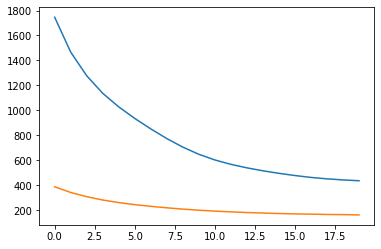

In [22]:
plt.plot([i for i in range(len(train_epoch_losses))], train_epoch_losses)
plt.plot([i for i in range(len(val_epoch_losses))], val_epoch_losses)

In [39]:
def predict(sentence):
    model.eval()
    sentence = word_tokenize(sentence)
    sentence = dataset.src_word2index.indexify_sentence(sentence)
    sentence = torch.LongTensor(dataset.pad(sentence)).unsqueeze(0).to(device)
    tgt = torch.zeros((1, max_sequence_length), dtype=torch.long)

    for i in range(max_sequence_length):
        out = model.forward(sentence, tgt, np_mask)

        out = F.softmax(out.squeeze()).detach().cpu().numpy()
        a = [i for i in range(len(out[i]))]
        tgt[0][i] = np.random.choice(a, p=out[i])

    print(dataset.tgt_word2index.sentencify_indices(tgt.squeeze().tolist()))